In [1]:
import numpy as np
import scipy.io
from scipy.integrate import solve_ivp
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms

# imports custom RNCRN functions that are used throughout multiple  notebooks 
import os, sys 
from pathlib import Path
module_path = str(Path(os.path.abspath('')).parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from functions.target_systems import supercritical_hopf_normal_form 
from functions.RNCRN_tools import load_tf_models_params, save_crn, convert_RNCRN_params_to_CRN, read_crn_txt, new_initial_conditions, stoch_mat_to_mass_action

from functions.RNCRN_phase_plane import * 


In [2]:
# loads the previously trained model for quasi-static analysis 
filename = 'models/hopf_critical_example'
matcontents = scipy.io.loadmat(filename+'.mat')
first_layer_weights = matcontents['first_layer_weights']
first_layer_biases = matcontents['first_layer_biases'][0]
output_layer_weights = matcontents['output_layer_weights']
N = len(matcontents['first_layer_biases'][0])
gamma = matcontents['gamma'][0][0]
beta_1 = matcontents['beta'][0][0]
tau = matcontents['alpha'][0][0] # abuse of notation - but intentional

kernel_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_weights'])
bias_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_biases'][0])
kernel_initializer_second = tf.keras.initializers.constant(matcontents['output_layer_weights'])

def smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*gamma*tau))/tau
get_custom_objects().update({'smooth_max_activation': Activation(smooth_max_activation)})

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,), name=''),
  tf.keras.layers.Dense(N, activation='smooth_max_activation', kernel_initializer=kernel_initializer_first, bias_initializer=bias_initializer_first),
  tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_initializer = kernel_initializer_second),
])

In [3]:
# loads the previously trained model for compilation into a chemical reaction network (using helper functions)
params, number_of_exec_species, number_of_chemical_perceptrons = load_tf_models_params(filename+'.mat')

# define time-scale parameter to rescale appropriate rate constants in the chemical reaction network
time_scale = 0.01

# creates zero initial conditions for all chemical species (will be overwritten later)
inits = np.zeros(number_of_exec_species+number_of_chemical_perceptrons)

# location to store the CRN file for this RNCRN 
crn_file = 'CRNs/hopf_critical.txt'

# converts RNCRN parameters into a chemical reaction network and saves as a raw txt file 
save_crn(crn_file, convert_RNCRN_params_to_CRN(params, time_scale, inits) )

# reads the previously saved chemical reaction network file returning the key stoichiometry and kinetic matrices 
species, reaction_rates, react_stoch, prod_stoch, stoch_mat, number_species, number_reactions, initial_concs = read_crn_txt(crn_file)

# groups stoichiometry matrices for use in ODE simulation 
args_tup_rncrn = (reaction_rates, react_stoch, stoch_mat,)

In [4]:
# sets the executive species domain  
xlower_limit = 4
xupper_limit = 5
ylower_limit = 3.5
yupper_limit = 5.5
lower_limit = 3;
upper_limit = 7;
vis_step = 0.25;

step_size = 0.015;
step_size_par = 0.1;

# recall parameters used to shift the non-physical Hopf bifurication
a = 5;

# sets the time length for the trajectory simulations 
tFinal = 250;

In [5]:
# numerical integrations of trajectories for the target system (shifted homoclinic orbit) and the RNCRN approximation  
# these trajectories correspond to trajectories in Figure 9 in Appendix A.3
# - TARGET SYSTEM
inits = [2, 2];
args_tup = (a, 0, 0)
sol_2= solve_ivp(supercritical_hopf_normal_form, [0, tFinal], inits, args=args_tup, rtol=10e-8)

# - RNCRN
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':2, 'X_2': 2})
sol_rncrn_2 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

In [6]:
# Vector fields for the target system (shifted homoclinic orbit) and the quasi-static vector field for the RNCRN approximation  
# these vector fields correspond to the gray arrows in Figure 9 in Appendix A.3
# - TARGET SYSTEM
x1_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")
x2_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")
x1v, x2v = np.meshgrid(x1_train, x2_train, indexing='ij')
nx1 = len(x1_train)
nx2 = len(x2_train)
critical_param = 0
x1v, x2v = np.meshgrid(x1_train, x2_train, indexing='ij')
D = critical_param -np.power(x1v-a, 2) -np.power(x2v-a, 2)
g_1 = D*(x1v-a) - (x2v-a)
g_2 = D*(x2v-a) + (x1v-a)
target_vf_x1_1 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_1 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# - RNCRN
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))


# Approximate quasi-static error
print('(x1, r=0)', np.mean(np.square(target_vf_x1_1-res_x1_1)))
print('(x2, r=0)', np.mean(np.square(target_vf_x2_1-res_x2_1)))

8/8 [==============================] - 0s 1ms/step
(x1, r=0) 3.17449
(x2, r=0) 0.7746194


C:\Users\ad1114\AppData\Local\Temp\ipykernel_19756\2637833095.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


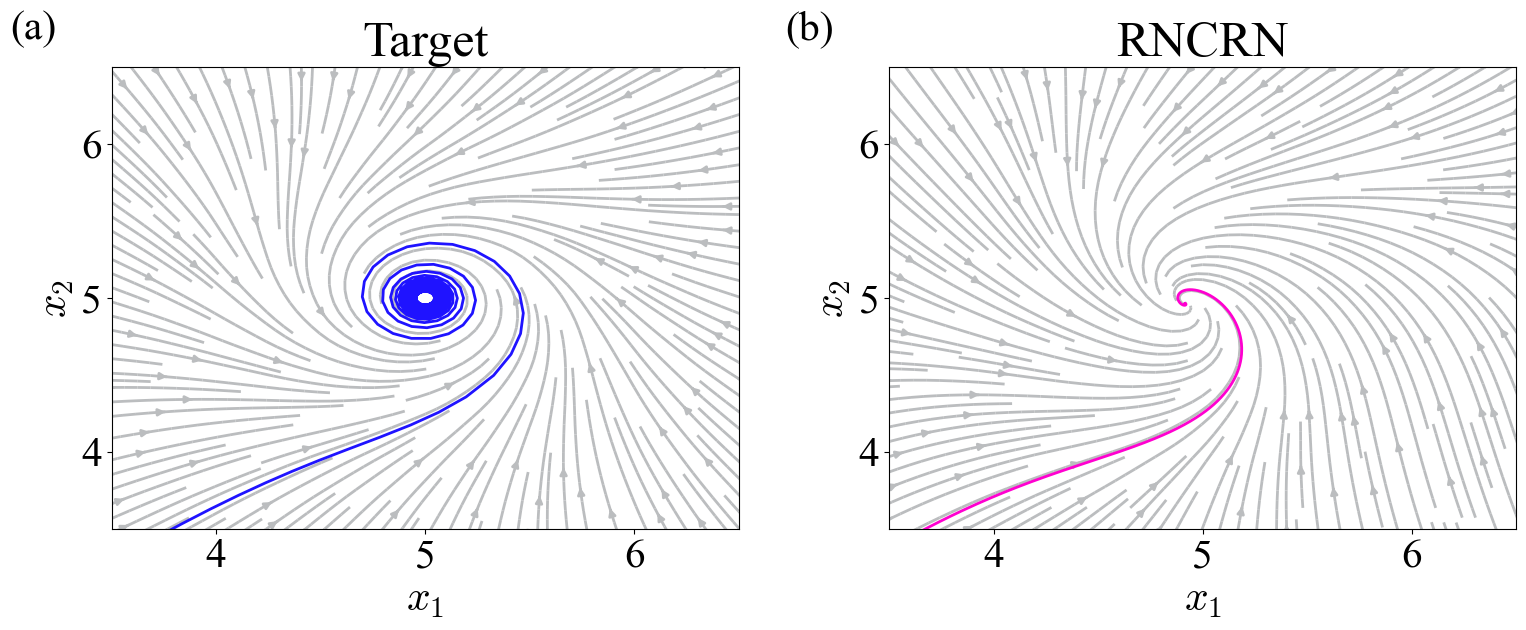

In [7]:
# plot some figures for visualisation  of the target system and RNCRN approximation  
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']
mpl.rcParams['figure.figsize'] = [16, 7]
fig, axs = plt.subplot_mosaic([['(a)', '(b)'],],  gridspec_kw={'width_ratios':[1,1]}, layout='constrained')

stablefp = 'limegreen'
linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  

density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', ha='right')


axa = axs['(a)']
axa.streamplot(x1_train, x2_train,target_vf_x1_1,target_vf_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axa.set_xlim(lower_limit+0.5, upper_limit-0.5)
axa.set_ylim(lower_limit+0.5, upper_limit-0.5)
axa.plot(sol_2.y[0,:], sol_2.y[1,:], color=ColList[0], )
axa.set_title('Target')
axa.set_xlabel('$x_1$')
axa.set_ylabel('$x_2$')
axa.set_xlim(3.5,6.5)
axa.set_ylim(3.5,6.5)

axd = axs['(b)']
axd.streamplot(x1_train, x2_train, res_x1_1, res_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('$x_1$')
axd.set_ylabel('$x_2$')
axd.set_title('RNCRN')
axd.set_xlim(3.5,6.5)
axd.set_ylim(3.5, 6.5)

plt.tight_layout()
plt.show()
fig.savefig('figures/hopf_bifurcation_critical.pdf', bbox_inches='tight')

In [8]:
lower_limit = 3
upper_limit = 7

vis_step = 0.25;
x1_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")
x2_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")

x1v, x2v = np.meshgrid(x1_train, x2_train, indexing='ij')

nx1 = len(x1_train)
nx2 = len(x2_train)

critical_param = 0

x1v, x2v = np.meshgrid(x1_train, x2_train, indexing='ij')
D = critical_param -np.power(x1v-a, 2) -np.power(x2v-a, 2)
g_1 = D*(x1v-a) - (x2v-a)
g_2 = D*(x2v-a) + (x1v-a)

target_vf_x1_1 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_1 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)

mu = -1 
res_x1_min1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1]))) + np.transpose(mu*x1v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu
res_x2_min1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1]))) + np.transpose(mu*x2v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu

mu = 0
res_x1_0 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1]))) + np.transpose(mu*x1v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu
res_x2_0 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1]))) + np.transpose(mu*x2v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu

mu = 1
res_x1_pos1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1]))) + np.transpose(mu*x1v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu
res_x2_pos1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1]))) + np.transpose(mu*x2v.reshape( g_1.shape[0], g_1.shape[1])) - 5*mu


8/8 [==============================] - 0s 1ms/step


In [9]:
# creates random perturbation of the RNCRN
sample_random = False
density = 1.5
seed_no = 2 
np.random.seed(seed_no)
noise_mag = 0.1


index_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

if sample_random:
    for i in np.arange(0, 21, 1):
        print(i)
        random_rates = list(np.array(reaction_rates)*(1+noise_mag*np.random.uniform(low=-1, high=1, size=(len(reaction_rates),))))
        args_tup_rncrn = (random_rates, react_stoch, stoch_mat,)
        sol_rncrn_rnd = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)
        plt.plot(sol_rncrn_rnd.y[id_dict['X_1'],:], sol_rncrn_rnd.y[id_dict['X_2'],:], color=ColList[1], )
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title('RNCRN')
        plt.tight_layout()
        plt.savefig('data/rand_rncrn_i_'+str(i)+'_seed_'+str(seed_no)+'.png', bbox_inches='tight')
        np.save('data/rand_rncrn_i_'+str(i)+'_seed_'+str(seed_no), np.array(random_rates))
        plt.clf()

In [10]:
rates = list(np.load('data/rand_rncrn_i_302_seed_4.npy'))
args_tup_rncrn = (rates, react_stoch, stoch_mat,)
sol_rncrn_rnd_osc = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

rates = list(np.load('data/rand_rncrn_i_10_seed_2.npy'))
args_tup_rncrn = (rates, react_stoch, stoch_mat,)
sol_rncrn_rnd_flat = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

In [11]:
rnd_reaction_rates = list(np.load('data/rand_rncrn_i_302_seed_4.npy'))

locations_start = 0
output_layer_weights_end = output_layer_weights.shape[0]*output_layer_weights.shape[1]
first_layer_weights_end = output_layer_weights_end + first_layer_weights.shape[0]*first_layer_weights.shape[1]
first_layer_biases_end = first_layer_weights_end + first_layer_biases.shape[0]
beta_end  = first_layer_biases_end + 2
gamma_end = beta_end + first_layer_biases.shape[0]
alpha_end = gamma_end + first_layer_biases.shape[0]

output_layer_weights_flat = np.asarray(rnd_reaction_rates[locations_start:output_layer_weights_end])
first_layer_weights_flat = time_scale*np.asarray(rnd_reaction_rates[output_layer_weights_end:first_layer_weights_end])
first_layer_biases_flat = time_scale*np.asarray(rnd_reaction_rates[first_layer_weights_end:first_layer_biases_end])
beta_1_flat = np.asarray(rnd_reaction_rates[first_layer_biases_end:beta_end])
gamma_flat = time_scale*np.asarray(rnd_reaction_rates[beta_end:gamma_end])
alpha_flat = time_scale*np.asarray(rnd_reaction_rates[gamma_end:alpha_end])
rnd_first_layer_weights = np.sign(first_layer_weights)*first_layer_weights_flat.reshape(first_layer_weights.shape)

omega_osc = rnd_first_layer_weights
rnd_first_layer_biases = np.sign(first_layer_biases)*first_layer_biases_flat.reshape(first_layer_biases.shape)
bias_osc = rnd_first_layer_biases
rnd_output_layer_weights = np.sign(output_layer_weights)*np.transpose(output_layer_weights_flat.reshape(output_layer_weights.shape[1],output_layer_weights.shape[0]))
alpha_osc = rnd_output_layer_weights

rnd_N = len(rnd_first_layer_biases)
rnd_gamma = gamma_flat
rnd_beta_1 = beta_1_flat
rnd_alpha = alpha_flat

rnd_kernel_initializer_first = tf.keras.initializers.constant(rnd_first_layer_weights)
rnd_bias_initializer_first = tf.keras.initializers.constant(rnd_first_layer_biases)
rnd_kernel_initializer_second = tf.keras.initializers.constant(rnd_output_layer_weights)

def rnd_smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*rnd_gamma*rnd_alpha))/rnd_alpha
get_custom_objects().update({'rnd_smooth_max_activation': Activation(rnd_smooth_max_activation)})

rnd_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,), name=''),
  tf.keras.layers.Dense(rnd_N, activation='rnd_smooth_max_activation', kernel_initializer=rnd_kernel_initializer_first, bias_initializer=rnd_bias_initializer_first),
  tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_initializer = rnd_kernel_initializer_second),
])

y_out = rnd_model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)

rnd_res_x1_osc =  rnd_beta_1[0] + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
rnd_res_x2_osc =  rnd_beta_1[1] + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

8/8 [==============================] - 0s 857us/step


In [12]:
rnd_reaction_rates = list(np.load('data/rand_rncrn_i_10_seed_2.npy'))
locations_start = 0
output_layer_weights_end = output_layer_weights.shape[0]*output_layer_weights.shape[1]
first_layer_weights_end = output_layer_weights_end + first_layer_weights.shape[0]*first_layer_weights.shape[1]
first_layer_biases_end = first_layer_weights_end + first_layer_biases.shape[0]
beta_end  = first_layer_biases_end + 2
gamma_end = beta_end + first_layer_biases.shape[0]
alpha_end = gamma_end + first_layer_biases.shape[0]

output_layer_weights_flat = np.asarray(rnd_reaction_rates[locations_start:output_layer_weights_end])
first_layer_weights_flat = time_scale*np.asarray(rnd_reaction_rates[output_layer_weights_end:first_layer_weights_end])
first_layer_biases_flat = time_scale*np.asarray(rnd_reaction_rates[first_layer_weights_end:first_layer_biases_end])
beta_1_flat = np.asarray(rnd_reaction_rates[first_layer_biases_end:beta_end])
gamma_flat = time_scale*np.asarray(rnd_reaction_rates[beta_end:gamma_end])
alpha_flat = time_scale*np.asarray(rnd_reaction_rates[gamma_end:alpha_end])
rnd_first_layer_weights = np.sign(first_layer_weights)*first_layer_weights_flat.reshape(first_layer_weights.shape)
rnd_first_layer_biases = np.sign(first_layer_biases)*first_layer_biases_flat.reshape(first_layer_biases.shape)
omega_uni = rnd_first_layer_weights
biases_uni = rnd_first_layer_biases
rnd_output_layer_weights = np.sign(output_layer_weights)*np.transpose(output_layer_weights_flat.reshape(output_layer_weights.shape[1],output_layer_weights.shape[0]))
alpha_uni = rnd_output_layer_weights

rnd_N = len(rnd_first_layer_biases)
rnd_gamma = gamma_flat
rnd_beta_1 = beta_1_flat
rnd_alpha = alpha_flat

rnd_kernel_initializer_first = tf.keras.initializers.constant(rnd_first_layer_weights)
rnd_bias_initializer_first = tf.keras.initializers.constant(rnd_first_layer_biases)
rnd_kernel_initializer_second = tf.keras.initializers.constant(rnd_output_layer_weights)

def rnd_smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*rnd_gamma*rnd_alpha))/rnd_alpha
get_custom_objects().update({'rnd_smooth_max_activation': Activation(rnd_smooth_max_activation)})

rnd_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,), name=''),
  tf.keras.layers.Dense(rnd_N, activation='rnd_smooth_max_activation', kernel_initializer=rnd_kernel_initializer_first, bias_initializer=rnd_bias_initializer_first),
  tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_initializer = rnd_kernel_initializer_second),
])

y_out = rnd_model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)

rnd_res_x1_node =  rnd_beta_1[0] + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
rnd_res_x2_node =  rnd_beta_1[1] + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

8/8 [==============================] - 0s 860us/step


C:\Users\ad1114\AppData\Local\Temp\ipykernel_19756\1282513320.py:72: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


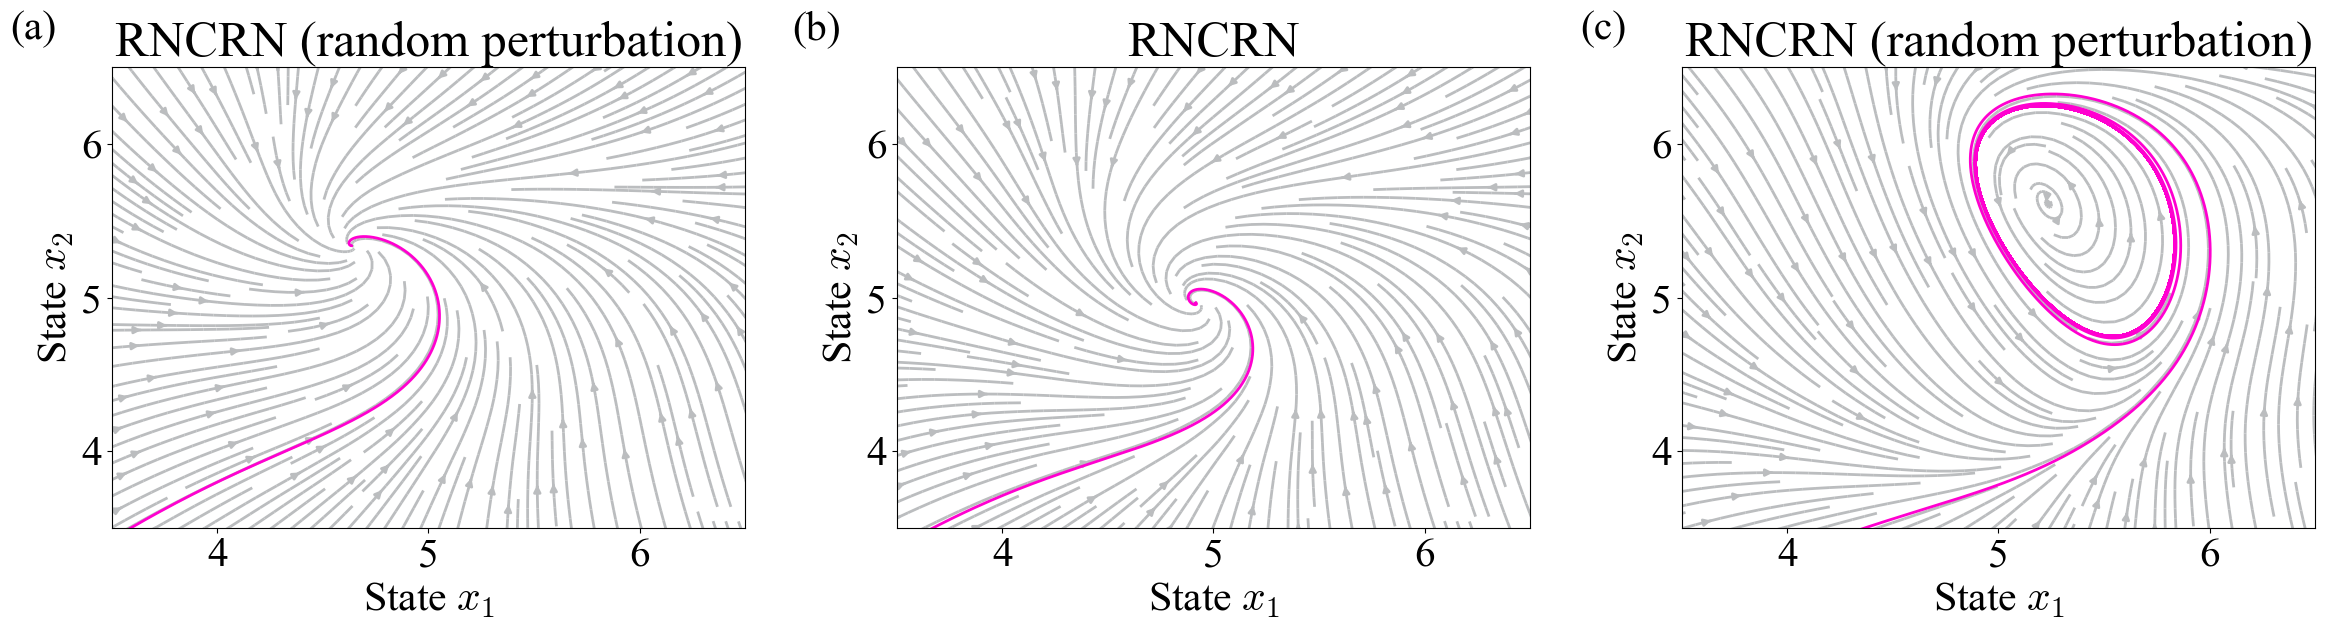

In [13]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']

mpl.rcParams['figure.figsize'] = [24, 7]

fig, axs = plt.subplot_mosaic([['(a)', '(b)', '(c)']],  gridspec_kw={'width_ratios':[1,1, 1]}, layout='constrained')

stablefp = 'limegreen'
linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  
density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', ha='right')

axd = axs['(a)']
axd.streamplot(x1_train, x2_train, rnd_res_x1_node, rnd_res_x2_node,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_rnd_flat.y[id_dict['X_1'],:], sol_rncrn_rnd_flat.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('State $x_1$')
axd.set_ylabel('State $x_2$')
axd.set_title('RNCRN (random perturbation)')
axd.set_xlim(3.5,6.5)
axd.set_ylim(3.5, 6.5)

axd = axs['(b)']
axd.streamplot(x1_train, x2_train, res_x1_0, res_x2_0,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('State $x_1$')
axd.set_ylabel('State $x_2$')
axd.set_title('RNCRN')
axd.set_xlim(3.5,6.5)
axd.set_ylim(3.5, 6.5)


axd = axs['(c)']
axd.streamplot(x1_train, x2_train, rnd_res_x1_osc, rnd_res_x2_osc,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_rnd_osc.y[id_dict['X_1'],:], sol_rncrn_rnd_osc.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('State $x_1$')
axd.set_ylabel('State $x_2$')
axd.set_title('RNCRN (random perturbation)')
axd.set_xlim(3.5,6.5)
axd.set_ylim(3.5, 6.5)

plt.tight_layout()
plt.show()
fig.savefig('figures/hopf_bifurcation_w_random.pdf', bbox_inches='tight')

In [14]:
# weights of the original RNCRN
alpha_mat, omega_mat, bias_vec, beta, gamma, tau = params

print('original RNCRN')

print('omega_mat_0')
for val in omega_mat[:,0]:
    print(f'{val:.3f}', '\\\\')

print('omega_mat_1')
for val in omega_mat[:,1]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_0')
for val in alpha_mat[0,:]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_1')
for val in alpha_mat[1,:]:
    print(f'{val:.3f}', '\\\\')

print('bias_vec')
for val in bias_vec[:,0]:
    print(f'{val:.3f}', '\\\\')

original RNCRN
omega_mat_0
-3.672 \\
0.911 \\
-1.391 \\
0.241 \\
-0.454 \\
-0.077 \\
omega_mat_1
2.091 \\
-3.981 \\
-1.433 \\
1.058 \\
-0.922 \\
-0.073 \\
alpha_mat_0
0.492 \\
-0.117 \\
2.229 \\
-0.708 \\
-1.146 \\
1.363 \\
alpha_mat_1
-0.283 \\
0.657 \\
2.199 \\
-1.294 \\
-2.632 \\
3.118 \\
bias_vec
2.243 \\
10.838 \\
10.718 \\
-3.164 \\
7.959 \\
3.002 \\


In [19]:
print('oscillating RNCRN')

print('omega_mat_0')
for val in omega_osc[0,:]:
    print(f'{val:.3f}', '\\\\')

print('omega_mat_1')
for val in omega_osc[1,:]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_0')
for val in alpha_osc[:,0]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_1')
for val in alpha_osc[:,1]:
    print(f'{val:.3f}', '\\\\')

print('bias_vec')
for val in bias_osc:
    print(f'{val:.3f}', '\\\\')

oscillating RNCRN
omega_mat_0
-3.912 \\
0.843 \\
-1.345 \\
0.222 \\
-0.481 \\
-0.083 \\
omega_mat_1
2.059 \\
-3.679 \\
-1.552 \\
1.070 \\
-0.929 \\
-0.075 \\
alpha_mat_0
0.532 \\
-0.106 \\
2.315 \\
-0.693 \\
-1.116 \\
1.467 \\
alpha_mat_1
-0.286 \\
0.645 \\
1.989 \\
-1.231 \\
-2.614 \\
3.228 \\
bias_vec
2.025 \\
10.419 \\
11.140 \\
-3.029 \\
8.754 \\
3.069 \\


In [21]:
print('uni-stable RNCRN')
print('omega_mat_0')
for val in omega_uni[0,:]:
    print(f'{val:.3f}', '\\\\')

print('omega_mat_1')
for val in omega_uni[1, :]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_0')
for val in alpha_uni[:, 0]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_1')
for val in alpha_uni[:, 1]:
    print(f'{val:.3f}', '\\\\')

print('bias_vec')
for val in biases_uni:
    print(f'{val:.3f}', '\\\\')

uni-stable RNCRN
omega_mat_0
-3.667 \\
0.920 \\
-1.396 \\
0.241 \\
-0.451 \\
-0.077 \\
omega_mat_1
2.085 \\
-4.016 \\
-1.432 \\
1.065 \\
-0.924 \\
-0.073 \\
alpha_mat_0
0.493 \\
-0.117 \\
2.223 \\
-0.711 \\
-1.147 \\
1.355 \\
alpha_mat_1
-0.284 \\
0.657 \\
2.192 \\
-1.299 \\
-2.609 \\
3.110 \\
bias_vec
2.220 \\
10.930 \\
10.815 \\
-3.142 \\
7.890 \\
2.991 \\
